In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import model_function

In [34]:
exponential_count = 2
parameter_count = exponential_count*2+1

Load a model or creat a new one?

In [35]:
load = False
model_path ='models/2024-01-08_14-17-45_3exp_params_517_points_50/model.keras'

In [36]:
df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')
# df = pd.read_csv('measurements/E_4_20ms_20231103_14_55_46.csv', sep=', ')
df.head()

C:\Users\crpdn\AppData\Local\Temp\ipykernel_11876\431649043.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')


,Ch1(mA),Ch2(mA),Ch3(mA),Ch4(mA),Ch5(mA),Ch6(mA),Ch7(mA),Ch8(mA),Ch9(mA),Ch10(mA),...,Ch14(mA),Ch15(mA),Ch16(mA),Channel state,On time,Off time,Pulse number,Pattern,Time,Probeflag
0,0,0,0,0.03421,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,1,1/1000,0.087664,False
1,0,0,0,0.04888,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,2,1/1000,0.182584,False
2,0,0,0,0.06354,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,3,1/1000,0.283189,False
3,0,0,0,0.08309,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,4,1/1000,0.376060,False
4,0,0,0,0.09775,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,5,1/1000,0.469858,False


In [37]:
df_params = pd.read_csv('outputs\C_4_1000_20231213_14_15_50_params_2exp.csv', sep=',', header = None)
# df = pd.read_csv('measurements/E_4_20ms_20231103_14_55_46.csv', sep=', ')
df_params.head()
zero_rows = df_params[df_params.eq(0).all(axis=1)].index.tolist()

In [38]:
df = df[ ['Pattern','Time','Ch4(mA)','On time', 'Off time']]
df = df.rename(columns={'Ch4(mA)': 'Current'})
df = df.drop(df.index[:50*10])
df.head()

,Pattern,Time,Current,On time,Off time
500,11/1000,79.005742,1.564,74,155
501,11/1000,79.230081,1.422,74,155
502,11/1000,79.460954,1.329,74,155
503,11/1000,79.690012,1.261,74,155
504,11/1000,79.921769,1.212,74,155


In [39]:
target_points = 50
cutoff_current_min = 0
must_be_growth = False
must_be_decay = False
min_gradient =0
max_final_gradient = 1

Text(0.5, 1.0, 'Data to be modeled')

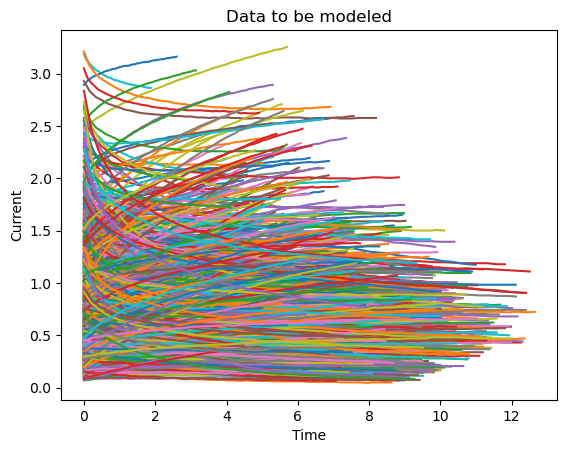

In [40]:
grouped = df.groupby('Pattern')
list_of_dfs = [group for _, group in grouped]
list_of_dfs_fixed = []
for data in list_of_dfs:    
    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    points = len(y_current)    
    #(data.loc[0,'Off time'])
    if len(y_current) != target_points:
        print(points)
        continue
    assert x_time.shape == y_current.shape
    assert points == target_points
    if np.min(y_current)>cutoff_current_min and np.max(np.abs(np.gradient(y_current,y_current.index)))>min_gradient and np.min(np.abs(np.gradient(y_current,y_current.index)[:-10]))<max_final_gradient:
        if must_be_growth:
            if y_current.iloc[0]<y_current.iloc[-1]:
                plt.plot(x_time, y_current, '-')
                list_of_dfs_fixed.append(data)
        elif   must_be_decay:
            if y_current.iloc[0]>y_current.iloc[-1]:
                plt.plot(x_time, y_current, '-')
                list_of_dfs_fixed.append(data)          
        else:
            plt.plot(x_time, y_current, '-')
            list_of_dfs_fixed.append(data)
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Data to be modeled')

In [41]:
#initialize array of expected shape
X_data = np.zeros((len(list_of_dfs_fixed),3))
prev_on_time = 0
prev_off_time = 0
for i in range(len(list_of_dfs_fixed)):

    data = list_of_dfs_fixed[i]
    prev_on_time = data['On time'].iloc[0]
    prev_off_time = data['Off time'].iloc[0]

    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    
    if len(y_current) != target_points:
        print(points)
        continue
    if np.max(y_current)>cutoff_current_min:
        label = np.column_stack((x_time,y_current))  
        features =  np.array([y_current.iloc[0], data['On time'].iloc[0], data['Off time'].iloc[0]])
        X_data[i,:] = features
    prev_on_time = data['On time'].iloc[0]
    prev_off_time = data['Off time'].iloc[0]

print(f"X shape:{X_data.shape}")

X shape:(990, 3)


In [42]:
x_data_df = pd.DataFrame(X_data)

x_data_df.drop(zero_rows, inplace= True)
X_data = x_data_df.values

In [43]:
df_params.drop(zero_rows, inplace= True)
y_data = df_params.values
print(f"y shape:{y_data.shape}")

y shape:(764, 5)


In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, train_size=0.5)


In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



In [46]:
import keras



 

def create_nn(dropout_rate = 0.5):
    global X_train, points
    # Input layer, the number of input nodes is governed by X_data.shape[1]
    # X_data.shape[1] is the number of columns in X_data
    inputs = keras.Input(shape=(X_train.shape[1],), name='input')
    x = inputs
    # Dense layers 
    #layers_norm = keras.layers.BatchNormalization()(inputs)
    dropout_layer = False
    params_per_layer = 100
    number_of_layers = 40
    for i in range(number_of_layers):    
        x = keras.layers.Dense(params_per_layer, 'linear')(x)
        if dropout_layer:
            x = keras.layers.Dropout(rate=dropout_rate)(x)
    parameters = keras.layers.Dense(parameter_count)(x)


    return keras.Model(inputs=inputs, outputs=parameters, name="current_function_prediction")

In [47]:
if load:
    model = keras.models.load_model(model_path)
else:
    model = create_nn()

model.summary()

Model: "current_function_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_42 (Dense)            (None, 100)               400       
                                                                 
 dense_43 (Dense)            (None, 100)               10100     
                                                                 
 dense_44 (Dense)            (None, 100)               10100     
                                                                 
 dense_45 (Dense)            (None, 100)               10100     
                                                                 
 dense_46 (Dense)            (None, 100)               10100     
                                                                 
 dense_47 (Dense)            (None, 100

In [48]:

def compile_model(model):
    sgd = keras.optimizers.RMSprop(clipnorm=5)
    model.compile(optimizer='adam', #'adam'
                  loss = 'mean_absolute_percentage_error' )
    


number_of_epochs = 500




earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss",baseline = 1, patience=number_of_epochs,restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.8, 
                              patience=50, 
                              min_lr=1e-6)
compile_model(model)

import seaborn as sns
def plot_history(history, metrics, y_lim):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    if y_lim !=0:
        plt.ylim(0,y_lim)
    plt.xlabel("epochs")
    plt.ylabel("metric")



In [49]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=number_of_epochs,
                    validation_data = (X_val,y_val),
                    callbacks=[
                                # earlystopper,
                               reduce_lr
                               ],
                    verbose=2)

Epoch 1/500
5/5 - 5s - loss: 1040.9656 - val_loss: 539.0851 - lr: 0.0010 - 5s/epoch - 1s/step
Epoch 2/500
5/5 - 0s - loss: 379.6525 - val_loss: 330.8061 - lr: 0.0010 - 57ms/epoch - 11ms/step
Epoch 3/500
5/5 - 0s - loss: 182.8984 - val_loss: 137.8978 - lr: 0.0010 - 59ms/epoch - 12ms/step
Epoch 4/500
5/5 - 0s - loss: 114.6157 - val_loss: 113.1113 - lr: 0.0010 - 56ms/epoch - 11ms/step
Epoch 5/500
5/5 - 0s - loss: 116.8033 - val_loss: 114.6992 - lr: 0.0010 - 55ms/epoch - 11ms/step
Epoch 6/500
5/5 - 0s - loss: 116.3550 - val_loss: 137.2218 - lr: 0.0010 - 57ms/epoch - 11ms/step
Epoch 7/500
5/5 - 0s - loss: 165.2910 - val_loss: 145.0949 - lr: 0.0010 - 60ms/epoch - 12ms/step
Epoch 8/500
5/5 - 0s - loss: 119.9266 - val_loss: 193.7759 - lr: 0.0010 - 59ms/epoch - 12ms/step
Epoch 9/500
5/5 - 0s - loss: 187.2119 - val_loss: 135.2168 - lr: 0.0010 - 54ms/epoch - 11ms/step
Epoch 10/500
5/5 - 0s - loss: 124.1475 - val_loss: 185.4351 - lr: 0.0010 - 54ms/epoch - 11ms/step
Epoch 11/500
5/5 - 0s - loss: 16

KeyboardInterrupt: 

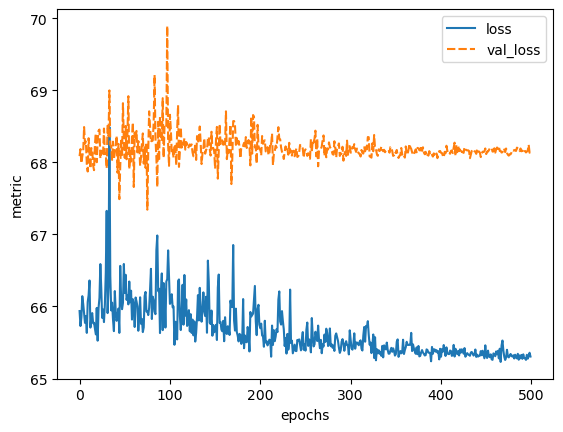

In [ ]:
# call the plot_history function with the apropriate object and string
plot_history(history, ['loss', 'val_loss'], 0)

In [ ]:
# Save the model
# import os
# from datetime import datetime
# current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# # filename = f"{current_date}_RMSE_params_{model.count_params()}_points_{points}.keras"
# # model.save('models/'+filename)


# folder_path = f'models/{current_date}_{exponential_count}exp_params_{model.count_params()}_points_{points}'
# os.makedirs(folder_path, exist_ok=True)
# model.save(folder_path+'/model.keras')

In [ ]:
# make prediction on test data
y_train_prediction = model.predict(X_train)

17/17 [==============================] - 0s 1ms/step
